In [1]:
import spacy
import numpy as np
import re, string
import matplotlib.pyplot as plt
import random as rd
from math import sqrt
import operator
import re
import json
import skfuzzy as fuzz
from scipy import stats
import pandas as pd
pd.set_option("display.max_rows", 600)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial import distance
import fr_core_news_md
nlp = spacy.load('fr_core_news_md')

/home/luis/anaconda3/envs/titleProject/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'fr_core_news_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
def triangleFunction(points, xrange):
    values = {}
    for k, v in xrange:
        if v <= points['a']:
            values[k]=0
        elif (v >= points['a'] and v <= points['b']):
            values[k]=(v-points['a'])/(points['b'] - points['a'])
        elif v >= points['b'] and v <= points['c']:
            values[k]=(points['c']-v)/(points['c'] - points['b'])
        elif v >= points['c']:
            values[k]=0
    return values
pass

def linearFunction(points, xrange):
    values = {}    
    for k, v in xrange:
        if v<points['a']:
            values[k]=0
        elif (v>=points['a'] and v<points['b']):
            values[k]=(v-points['a'])/(points['b'] - points['a'])
        elif v>=points['b']:
            values[k]=1
    return values
pass

In [3]:
def getAxisValues(axis,stepSize):
    return np.arange(axis['xmin'], axis['xmax'], stepSize)
pass

In [4]:
def getTokens(_sentences, opc, isArray):
    tokens=[]
    if isArray:
        for sentence in _sentences:
            words=nlp(sentence) #filtre_stopfr(word_tokenize(sentence, language="french"))
            for word in words:
                if opc==1 and len(word.text) > 1 and word.lemma_ not in tokens and word.is_stop is False:
                    tokens.append(word.lemma_)
                elif opc==2 and len(word.text) > 1 and word.lower_ not in tokens and word.is_stop is False:
                    tokens.append(word.lower_)
                elif opc==3 and len(word.text) > 1 and word.is_stop is False:
                    tokens.append(word.lower_)
    else:
        words=nlp(_sentences)
        for word in words:
            if opc and len(word.text) > 1 and word.lemma_ not in tokens and word.is_stop is False:
                tokens.append(word.lemma_)
            elif not opc and len(word.lower_) > 1 and word.lower_ not in tokens and word.is_stop is False:
                tokens.append(word.lower_)
    return tokens

In [5]:
def normalize(arr,t_min,t_max):
    norm_arr = arr
    #norm_arr_2 = []
    v_max = v_min = arr[0][0]
    for v in arr: 
        if(v_max < max(v)): v_max = max(v) 
        if(v_min > min(v)): v_min = min(v)
    diff_arr = v_max - v_min
    diff = t_max - t_min
    
    for l in range(len(arr)):
        for i in range(len(arr[l])):
            temp = (((arr[l][i] - v_min)*diff)/diff_arr) + t_min
            norm_arr[l][i]=temp
            #norm_arr_2.append(temp)
        #norm_arr.append(norm_arr_2)
    return norm_arr

In [6]:
def getMatrix(_tokens, _rows, lemmatize):
    matrix = np.zeros((len(_rows),len(_tokens)))
    f = 0
    for l in _rows:
        c = 0
        words = getTokens(l,lemmatize, False)
        for token in _tokens:
            if token in words : matrix[f][c]=1
            c+=1
        f+=1
    matrixT = matrix.transpose()
    producto_M = matrix.dot(matrixT)
    #MatrixE = np.linalg.matrix_power(producto_M,2)
    return normalize(producto_M,0,1)

In [7]:
def getMatrixTfidf(_tokens, _rows, lemmatize):
    matrix = np.zeros((len(_rows),len(_tokens)))
    f = 0
    for l in _rows:
        c = 0
        words = getTokens(l,lemmatize, False)
        for token in _tokens:
            if token in words :
                try:
                    matrix[f][c]=tfidf_df[token]['20081219_xinhuanet_fr_f090592976aaaf013cdc254f70319116']
                except:
                    matrix[f][c]=0
            c+=1
        f+=1
    matrixT = matrix.transpose()
    producto_M = matrix.dot(matrixT)
    #MatrixE = np.linalg.matrix_power(producto_M,2)
    return normalize(producto_M,0,1)

In [8]:
def textualEnergy(_MatrixCurrent, _curr_index):
    vSum=0
    for l in _MatrixCurrent:
        vSum+=sum(l)
    vAvg=vSum/len(_MatrixCurrent)
    if (sum(_MatrixCurrent[_curr_index]) > vAvg): return True
    else: return False

In [9]:
def getIndex(self_current_row):
    m_trie=sorted(self_current_row, reverse=1)
    for ite in m_trie:
        curr_index_list = np.where(self_current_row == ite)
        #print(self_current_row,ite,curr_index_list,'-----------')
        for curr_index in curr_index_list[0]:
            if MatrixCurrent[curr_index] is not self_current_row and curr_index not in list_used:
                if textualEnergy(MatrixCurrent,curr_index):
                    #print(curr_index, list(lemmas.keys())[curr_index])
                    return int(curr_index)

In [10]:
def cleanSentences(o_sentences):
    s_sentences={}
    contador=0
    for sentence in o_sentences:        
        if 0<len(sentence.split())<100: s_sentences[contador] = sentence
        contador+=1
    return s_sentences

In [11]:
def openCorpus(pathJason, idNews):
    pathCorpus = "/media/luis/respaldo/corpora/french-docs/"
    #Reading Jason with all information about corpus
    with open(pathCorpus+pathJason, "r") as file:
        data = json.load(file)
    #Reading name's file of news
    articles=[]
    articles2=[]
    for key in data :
        articles.append(data[key]['document_path'])
        articles2.append(pathCorpus+data[key]['document_path'])
    #Reading the selected news
    news = open(pathCorpus+articles[idNews],'r').readlines()
    #Extracting paragraphs
    reg_str = "<p>(.*?)</p>"
    #news[1] ignoring the first element of the list, usually the title
    #[0] is to get directly the only element in list in str format
    filteredText = re.findall(reg_str, news[1])[0].replace('\\','')
    segmentedSent = nlp(filteredText)
    assert segmentedSent.has_annotation("SENT_START")
    vectorSent=[]
    for sent in segmentedSent.sents:
        vectorSent.append(sent.text)
    #Formatting into a dictionary of sentences
    return cleanSentences(vectorSent), calculateTfidf(articles2)

In [12]:
def calculateTfidf(_articles):
    text_titles = [Path(text).stem for text in _articles]
    tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words=stopwords.words('french'))
    tfidf_vector = tfidf_vectorizer.fit_transform(_articles)
    return pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())
    

In [13]:
#Looking for news in position 0
#Lemma 1 : lemmes unique = ; 2 = lower case  unique; 3 = lower case
lemma = 1
dictSentences, tfidf_df = openCorpus("french-docs.json", 0)
tokens =  getTokens(dictSentences.values(),lemma, True)

In [14]:
MatrixVocab = getMatrix(tokens, dictSentences.values(), lemma)

In [15]:
MatrixVocabTF = getMatrixTfidf(tokens, dictSentences.values(), lemma)

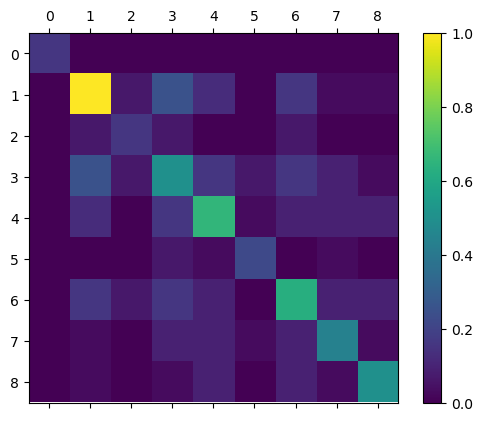

In [16]:
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(MatrixVocab, interpolation ='nearest')
figure.colorbar(caxes)
plt.show()

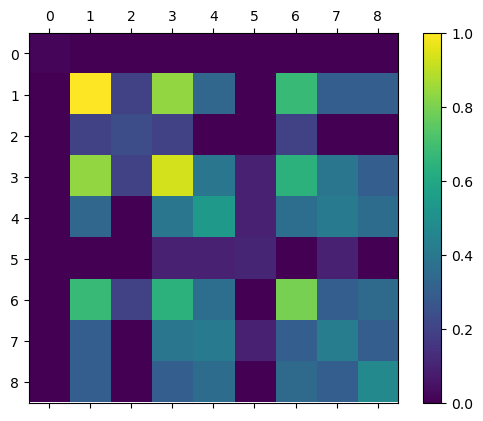

In [17]:
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(MatrixVocabTF, interpolation ='nearest')
figure.colorbar(caxes)
plt.show()

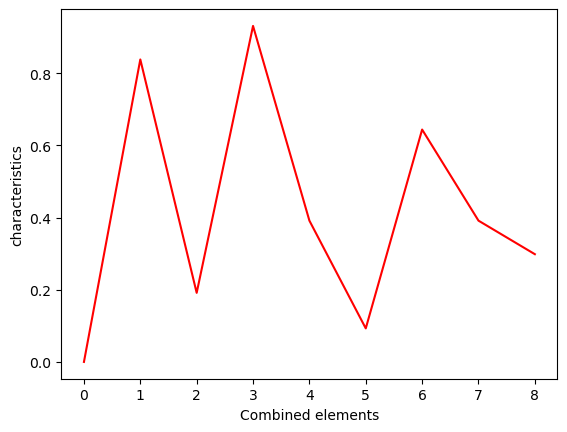

In [18]:
i=3
plt.plot(MatrixVocabTF[i],'r')
plt.ylabel("characteristics")
plt.xlabel("Combined elements")
plt.show()
#We observe that the sentence with more energy is positioned on index 3.
#The sentansces closest are on index: 1, 6

In [19]:
fuzzyVector = []
for sent in MatrixVocabTF:
    fuzzyVector.append(sum(sent))
fuzzyVector = dict(zip(dictSentences.keys(), fuzzyVector))
# Setting a domain field.
vMin = min(fuzzyVector.values())
vMax = max(fuzzyVector.values())
vMean = np.median(list(fuzzyVector.values()))
xaxis = { 'xmin':vMin, 'xmax':vMax}

# Creating the values for the domain of all our membership functions.
xrange = getAxisValues(xaxis, 0.5)

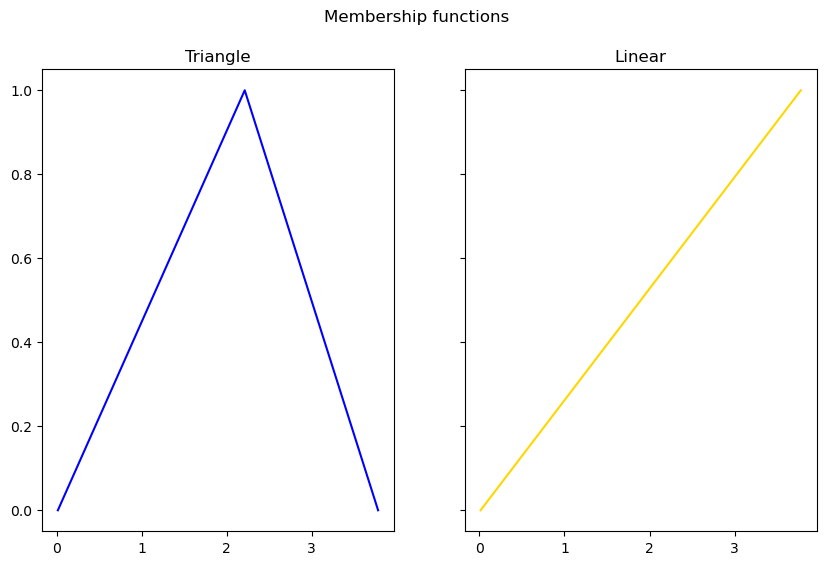

In [20]:
sortedValues = dict(sorted(fuzzyVector.items(), key=lambda item: item[1]))

linearPoints = {'a':vMin,  'b': vMax}
linearFunctionV = linearFunction(linearPoints, sortedValues.items())

trianglePoints = {'a':vMin,  'b': vMean , 'c': vMax}
triangleFunctionV = triangleFunction(trianglePoints, sortedValues.items())

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
axs[0].plot(sortedValues.values(), triangleFunctionV.values(), 'blue' )
axs[1].plot(sortedValues.values(), linearFunctionV.values(), 'gold' )
axs[0].title.set_text('Triangle')
axs[1].title.set_text('Linear')

# Setting the main title
plt.suptitle('Membership functions')

# Show us what you got!
plt.show()

In [21]:
#list to store the tokens and pos tags
idSentence=max(linearFunctionV, key=linearFunctionV.get)
sentence = nlp(dictSentences.get(idSentence))
p=[]
print("keys words = ")
for word in sentence:
    if word.pos_ in ['NOUN','PROPN','VERB'] and not word.is_stop:
        child = ""
        if len(list(word.children)) > 0: child = list(word.children)[0]
        if len(p) > 0:
            if p[-1] is not child : p.append(child)
            p.append(word.text)
        else: 
            p.append(child)
            p.append(word.text)
        print(word.head.text, word.text, [child for child in word.children])
print(p)

keys words = 
liée OMS [Selon, l']
liée visite [la, Dr]
visite Dr [du, Sambo]
Dr Sambo []
liée liée [OMS, ,, visite, est, éruption, ,, signalé, .]
liée éruption [à, l', choléra, Zimbabwe, implications]
éruption choléra [de]
éruption Zimbabwe [au]
éruption implications [et, à, ses, régionales]
étant donné []
signalé Afrique [l', Sud, Botswana]
Afrique Sud [du]
Afrique Botswana [et, le]
liée signalé [étant, que, Afrique, ont, cas]
signalé cas [des, choléra]
cas choléra [de]
[Selon, 'OMS', la, 'visite', du, 'Dr', '', 'Sambo', OMS, 'liée', à, 'éruption', de, 'choléra', au, 'Zimbabwe', et, 'implications', '', 'donné', l', 'Afrique', du, 'Sud', et, 'Botswana', étant, 'signalé', des, 'cas', de, 'choléra']


In [22]:
#list to store the tokens and pos tags
idSentence=max(linearFunctionV, key=linearFunctionV.get)
sentence = nlp(dictSentences.get(idSentence))
p=[]
print("keys words = ")
for word in sentence:
    #if word.pos_ in ['NOUN']:
    print(word.text, word.pos_, end=" -- ")
        
        #child = ""
        #if len(list(word.children)) > 0: child = list(word.children)[0]
        #if len(p) > 0:
        #    if p[-1] is not child : p.append(child)
        #    p.append(word.text)
        #else: 
        #    p.append(child)
        #    p.append(word.text)
        #print(word.head.text, word.text, [child for child in word.children])

keys words = 
Selon ADP -- l' DET -- OMS PROPN -- , PUNCT -- la DET -- visite NOUN -- du ADP -- Dr NOUN -- Sambo PROPN -- est AUX -- liée VERB -- à ADP -- l' DET -- éruption NOUN -- de ADP -- choléra NOUN -- au ADP -- Zimbabwe PROPN -- et CCONJ -- à ADP -- ses DET -- implications NOUN -- régionales ADJ -- , PUNCT -- étant VERB -- donné VERB -- que SCONJ -- l' DET -- Afrique PROPN -- du ADP -- Sud PROPN -- et CCONJ -- le DET -- Botswana PROPN -- ont AUX -- signalé VERB -- des DET -- cas NOUN -- de ADP -- choléra NOUN -- . PUNCT -- 

In [23]:
dictSentences.get(3)

"Selon l'OMS, la visite du Dr Sambo est liée à l'éruption de choléra au Zimbabwe et à ses implications régionales, étant donné que l'Afrique du Sud et le Botswana ont signalé des cas de choléra."

In [24]:
import numpy as np
import string

np.random.seed(1234)

In [54]:
initial = {} # start of a phrase
first_order = {} # second word only
second_order = {}

In [55]:
def remove_punctuation(s):
    return s.translate(str.maketrans('','',string.punctuation))

In [56]:
def add2dict(d, k, v):
    if k not in d:
        d[k] = []
    d[k].append(v)

# [cat, cat, dog, dog, dog, dog, dog, mouse, ...]

In [57]:
for line in dictSentences.values():
    tokens = remove_punctuation(line.rstrip().lower()).split()

    T = len(tokens)
    for i in range(T):
        t = tokens[i]
        if i == 0:
            # measure the distribution of the first word
            initial[t] = initial.get(t, 0.) + 1
        else:
            t_1 = tokens[i-1]
            if i == T - 1:
                # measure probability of ending the line
                add2dict(first_order, t_1, t)
            if i == 1:
                # measure distribution of second word
                # given only first word
                add2dict(first_order, t_1, t)
            else:
                add2dict(first_order, t_1, t)

In [ ]:
for line in dictSentences.values():
    tokens = remove_punctuation(line.rstrip().lower()).split()

    T = len(tokens)
    for i in range(T):
        t = tokens[i]
        if i == 0:
            # measure the distribution of the first word
            initial[t] = initial.get(t, 0.) + 1
        else:
            t_1 = tokens[i-1]
            if i == T - 1:
                # measure probability of ending the line
                add2dict(second_order, (t_1, t), 'END')
            if i == 1:
                # measure distribution of second word
                # given only first word
                add2dict(first_order, t_1, t)
            else:
                t_2 = tokens[i-2]
                add2dict(second_order, (t_2, t_1), t)

In [60]:
# normalize the distributions
initial_total = sum(initial.values())
for t, c in initial.items():
    initial[t] = c / initial_total

In [61]:
# convert [cat, cat, cat, dog, dog, dog, dog, mouse, ...]
# into {cat: 0.5, dog: 0.4, mouse: 0.1}

def list2pdict(ts):
    # turn each list of possibilities into a dictionary of probabilities
    d = {}
    n = len(ts)
    for t in ts:
        d[t] = d.get(t, 0.) + 1
    for t, c in d.items():
        d[t] = c / n
    return d

In [62]:
for t_1, ts in first_order.items():
  # replace list with dictionary of probabilities
  first_order[t_1] = list2pdict(ts)
    
for k, ts in second_order.items():
    second_order[k] = list2pdict(ts)

In [36]:
def sample_word(d):
  # print "d:", d
    p0 = np.random.random()
    # print "p0:", p0
    cumulative = 0
    for t, p in d.items():
        cumulative += p
        if p0 < cumulative:
            return t
    assert(False) # should never get here

In [40]:
def generate():
    for i in range(4): # generate 4 lines
        sentence = []

        # initial word
        w0 = sample_word(initial)
        sentence.append(w0)

        # sample second word
        w1 = sample_word(first_order[w0])
        sentence.append(w1)

        # second-order transitions until END
        while True:
            w2 = sample_word(second_order[(w0, w1)])
            if w2 == 'END':
                break
            sentence.append(w2)
            w0 = w1
            w1 = w2
        print(' '.join(sentence))
        print()

In [47]:
sentence=remove_punctuation(dictSentences.get(3)).lower().split()

In [88]:
def sample_frequence(d, w_1):
    return d.get(w_1)
    for t, p in d.items():
        cumulative += p
        if p0 < cumulative:
            return t
    assert(False) # should never get here

In [52]:
dSent = {}
for i in range(len(sentence)):
    if i == 1:
        dSent[(sentence[i-1],sentence[i])] = first_order[sentence[i-1]].get(sentence[i])
    elif i > 1:
        dSent[(sentence[i-2], sentence[i-1], sentence[i])] = second_order[(sentence[i-2],sentence[i-1])].get(sentence[i])
dSent

{('selon', 'loms'): 1.0,
 ('selon', 'loms', 'la'): 1.0,
 ('loms', 'la', 'visite'): 1.0,
 ('la', 'visite', 'du'): 1.0,
 ('visite', 'du', 'dr'): 1.0,
 ('du', 'dr', 'sambo'): 1.0,
 ('dr', 'sambo', 'est'): 0.6666666666666666,
 ('sambo', 'est', 'liée'): 0.5,
 ('est', 'liée', 'à'): 1.0,
 ('liée', 'à', 'léruption'): 1.0,
 ('à', 'léruption', 'de'): 1.0,
 ('léruption', 'de', 'choléra'): 1.0,
 ('de', 'choléra', 'au'): 0.25,
 ('choléra', 'au', 'zimbabwe'): 1.0,
 ('au', 'zimbabwe', 'et'): 0.5,
 ('zimbabwe', 'et', 'à'): 1.0,
 ('et', 'à', 'ses'): 1.0,
 ('à', 'ses', 'implications'): 1.0,
 ('ses', 'implications', 'régionales'): 1.0,
 ('implications', 'régionales', 'étant'): 1.0,
 ('régionales', 'étant', 'donné'): 1.0,
 ('étant', 'donné', 'que'): 1.0,
 ('donné', 'que', 'lafrique'): 1.0,
 ('que', 'lafrique', 'du'): 1.0,
 ('lafrique', 'du', 'sud'): 1.0,
 ('du', 'sud', 'et'): 1.0,
 ('sud', 'et', 'le'): 1.0,
 ('et', 'le', 'botswana'): 1.0,
 ('le', 'botswana', 'ont'): 0.5,
 ('botswana', 'ont', 'signalé'): 1

In [64]:
dSent = {}
for i in range(len(sentence)):
    if i > 0:
        dSent[(sentence[i-1],sentence[i])] = first_order[sentence[i-1]].get(sentence[i])
dSent

{('selon', 'loms'): 0.5,
 ('loms', 'la'): 0.25,
 ('la', 'visite'): 0.2857142857142857,
 ('visite', 'du'): 0.6666666666666666,
 ('du', 'dr'): 0.3333333333333333,
 ('dr', 'sambo'): 0.75,
 ('sambo', 'est'): 0.5,
 ('est', 'liée'): 0.5,
 ('liée', 'à'): 1.0,
 ('à', 'léruption'): 0.1111111111111111,
 ('léruption', 'de'): 0.5,
 ('de', 'choléra'): 0.2777777777777778,
 ('choléra', 'au'): 0.14285714285714285,
 ('au', 'zimbabwe'): 0.5,
 ('zimbabwe', 'et'): 0.3333333333333333,
 ('et', 'à'): 0.1111111111111111,
 ('à', 'ses'): 0.1111111111111111,
 ('ses', 'implications'): 1.0,
 ('implications', 'régionales'): 1.0,
 ('régionales', 'étant'): 1.0,
 ('étant', 'donné'): 1.0,
 ('donné', 'que'): 1.0,
 ('que', 'lafrique'): 0.2,
 ('lafrique', 'du'): 0.5,
 ('du', 'sud'): 0.16666666666666666,
 ('sud', 'et'): 1.0,
 ('et', 'le'): 0.1111111111111111,
 ('le', 'botswana'): 0.18181818181818182,
 ('botswana', 'ont'): 0.5,
 ('ont', 'signalé'): 0.3333333333333333,
 ('signalé', 'des'): 1.0,
 ('des', 'cas'): 0.16666666666

In [87]:
x=np.mean(list(dSent.values()))

In [92]:
for k, v in dSent.items():
    if v < x: print(k,"\t\t -------")
    else : print(k)

('selon', 'loms') 		 -------
('loms', 'la') 		 -------
('la', 'visite') 		 -------
('visite', 'du')
('du', 'dr') 		 -------
('dr', 'sambo')
('sambo', 'est') 		 -------
('est', 'liée') 		 -------
('liée', 'à')
('à', 'léruption') 		 -------
('léruption', 'de') 		 -------
('de', 'choléra') 		 -------
('choléra', 'au') 		 -------
('au', 'zimbabwe') 		 -------
('zimbabwe', 'et') 		 -------
('et', 'à') 		 -------
('à', 'ses') 		 -------
('ses', 'implications')
('implications', 'régionales')
('régionales', 'étant')
('étant', 'donné')
('donné', 'que')
('que', 'lafrique') 		 -------
('lafrique', 'du') 		 -------
('du', 'sud') 		 -------
('sud', 'et')
('et', 'le') 		 -------
('le', 'botswana') 		 -------
('botswana', 'ont') 		 -------
('ont', 'signalé') 		 -------
('signalé', 'des')
('des', 'cas') 		 -------
('cas', 'de')


In [121]:
#bigramme > media
vMean = ['S']
for element in sent :
    if element[1] >= media: 
        for el in element[0]:
            for k , v in word2idx.items():
                if el == v and v is not vMean[-1]:
                    vMean.append(v)
                    #print(k, end=", \t\t\t")
                    break
        #print(element[1])

In [122]:
vMean

['S', 13, 26, 31, 16, 19, 51, 10, 32, 22, 23, 5, 64, 68, 10, 32]

In [111]:
vMost =['S']
#bigramme1 > bigramme2
for i in range(0,len(sent)-1,2):
    if sent[i][1] >= sent[i+1][1]:
        bigramme = sent[i][0]
    else:
        bigramme = sent[i+1][0]
    for el in bigramme:
        for k , v in word2idx.items():
            if el == v and k not in vMost[-1]:
                vMost.append(k)
                #print(k+"\t", end=", \t\t")
                break
    #print()

In [118]:
vGen =['S']
#bigramme1 > bigramme2
for i in range(0,len(sent)-1,2):
    if sent[i][1] >= sent[i+1][1] and sent[i][1] > media:
        bigramme = sent[i][0]
    elif sent[i][1] < sent[i+1][1] and sent[i+1][1] > media:
        bigramme = sent[i+1][0]
    else:
        bigramme = []
    for el in bigramme:
        for k , v in word2idx.items():
            if el == v and k not in vGen[-1]:
                vGen.append(k)
                #print(k+"\t", end=", \t\t")
                break
    #print()

In [133]:
notOK=0
for i in text_int[3]:
    if i in vMean:
        notOK =0
    else:
        notOK +=1
    
    if notOK >=4: break
    else:
        for k , v in word2idx.items():
            if i == v :
                print(k, end=" ")
                break
                
    


selon loms la visite du dr sambo est liée à léruption de choléra au zimbabwe et à ses 

In [124]:
text_int[3]

[36,
 55,
 13,
 26,
 31,
 16,
 19,
 51,
 56,
 54,
 30,
 10,
 32,
 22,
 23,
 28,
 54,
 57,
 58,
 59,
 60,
 61,
 62,
 9,
 31,
 63,
 28,
 5,
 64,
 65,
 66,
 67,
 68,
 10,
 32]